This notebook is used to develop routines for building the time-dependent scale factors and depths in NEMO with variable volume (vvl).

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

from salishsea_tools import viz_tools, grid_tools

%matplotlib inline

The vertical grid spacing in NEMO with variable volume is time-dependent. NEMO dsitributes the expanssion/compression of the water column equally across all water cells according the this formula:

$e3t_t = e3t_0(1 + \eta / H) $

where $e3t_t$ is the time dependent vertical grid spacing, $\eta$ is the sea surface height and $H$ is the water column depth.  $e3t_0$ is the initial vertical grid spacing which is stored in the mesh mask file. It is the grid spacing if the sea surface heigh were zero. Also, 
$H = \sum_{k=0}^{jpk} e3t_0 *tmask$
where *tmask* is the mask on the T-grid and $jpk$ is the last grid cell.


The grid spacing on the w grid also follow this simple formula, as well as the depths.

$e3w_t = e3w_0(1 + \eta / H) $

$gdept_t = gdept_0(1 + \eta / H) $

$gdepw_t = gdepw_0(1 + \eta / H) $

Where $e3w$ means vertical grid spacing on W grid, $gdept$ means depth levels on T grid and $gdepw$ means depth levels on W grid. the underscore 0 indicates initial values from mesh mask file and underscore t means time-dependent. Note that in this formulation gdepw_t(k=0) = 0 always, so these depths can be thtough of as a pressure. To find the depths relative to $\eta=0$ you just need to subtract the sea surface height. See this notebook:

The U/V grids are slighlty more complicated and will be considered later. Basically, the ssh has to be interpolated onto the U/V grids.

Functions:
1. Calculate the water column thickness
2. Calculate adjustment factor, $adj = 1 + \eta / H
3. Calculate time-dependent grids



# Loading Data

In [2]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

bathy = grid.variables['Bathymetry'][:]
# Sample file for testing calculations
fT = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_T.nc')

In [3]:
ssh = fT.variables['sossheig']
tmask = mesh_mask.variables['tmask'][:]
e3t_0 = mesh_mask.variables['e3t'][:]
gdept_0 = mesh_mask.variables['gdept'][:]
gdepw_0 = mesh_mask.variables['gdepw'][:]
e3w_0 = mesh_mask.variables['e3w'][:]

# Functions

## Calculating $H$

In [4]:
def calculate_H(e3t0, tmask):
    """Calculate the initial water column thickness (H).

    :arg e3t0: initial vertical scale factors on T-grid.
               Dimensions: (depth, y, x).
    :type e3t0: :py:class:`numpy.ndarray`

    :arg tmask: T-grid mask. Dimensions: (depth, y, x)
    :type tmask: :py:class:`numpy.ndarray`

    :returns: the initial water column thickness. Dimensions: (y, x)

    """

    H = np.sum(e3t0*tmask, axis=0)

    return H

### Check
Timing

In [5]:
% timeit H = calculate_H(e3t_0[0,...], tmask[0,...])

10 loops, best of 3: 38.9 ms per loop


Plot $H$.

(898, 398)


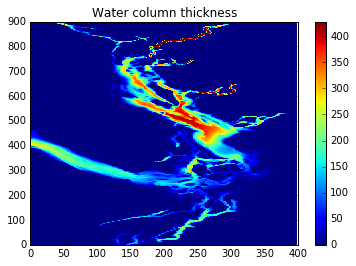

In [6]:
H = grid_tools.calculate_H(e3t_0[0,...], tmask[0,...])
print(H.shape)
plt.pcolormesh(H)
plt.colorbar()
plt.title('Water column thickness')



## Calculating adj

In [7]:
def calculate_adjustment_factor(H, ssh):
    """Calculate the time-dependent adjustment factor for variable volume in
    NEMO. adj = (1+ssh/H) and e3t_t = e3t_0*adj

    :arg H:  Water column thicnkess. Dimension: (y, x)
    :type H: :py:class:`numpy.array`

    :arg ssh: the model sea surface height. Dimensions: (time, y, x)
    :type ssh: :py:class:`numpy.ndarray`

    :returns: the adjustment factor with dimensions (time, y, x)
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        one_over_H = 1 / H
    one_over_H = np.nan_to_num(one_over_H)
    adj = (1 + ssh * one_over_H)
    return adj

### Check
Timing

In [8]:
% timeit adj = calculate_adjustment_factor(H, ssh)

1 loop, best of 3: 111 ms per loop


In [9]:
adj = grid_tools.calculate_adjustment_factor(H, ssh)
print(adj.shape)

(24, 898, 398)


Adjustment factor should be >1 when ssh >0. Quickly visualize.

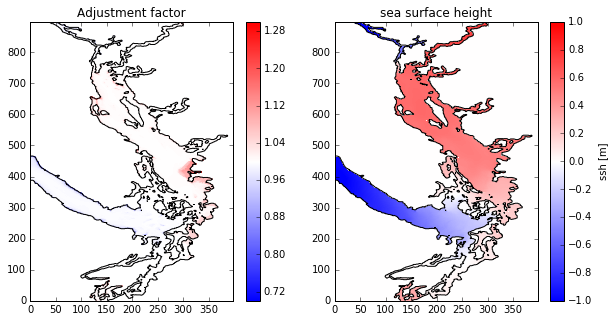

In [10]:
t=0
fig,axs=plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
mesh=ax.pcolormesh(np.ma.array(adj[t,:,:],mask=1-tmask[0,0,:,:]),
                   vmin=.7,vmax=1.3,cmap='bwr')
plt.colorbar(mesh, ax=ax)
viz_tools.plot_coastline(ax,grid)
ax.set_title('Adjustment factor')
ax=axs[1]
mesh=plt.pcolormesh(ssh[t,:,:], vmin=-1,vmax=1,cmap='bwr')
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('ssh [m]')
viz_tools.plot_coastline(ax,grid)
ax.set_title('sea surface height')

In [11]:
# Check adjustment factor is >=1 where ssh >=0.
inds=np.where(ssh[:]>=0) 
(adj[inds] >=1).all()

True

In [12]:
# Check adjustment factor is <1 where ssh <0.
inds=np.where(ssh[:]<0) 
(adj[inds] <1).all()

True

In [13]:
# Check adj <=1 is false when ssh >=0
inds=np.where(ssh[:]>=0) 
(adj[inds] <=1).all()

False

In [14]:
# Check adj >=1 is false when ssh <0
inds=np.where(ssh[:]<0) 
(adj[inds] >=1).all()

False

## Calculating scale factors and depths

In [15]:
def calculate_time_dependent_grid(
    e3t0,
    tmask,
    ssh,
    input_vars,
):
    """ Calculate the time dependent vertical grids and scale factors for
    variable volume in NEMO.

    :arg e3t0: initial vertical scale factors on T-grid.
               Dimensions: (depth, y, x).
    :type e3t0: :py:class:`numpy.ndarray`

    :arg tmask: T-grid mask. Dimensions: (depth, y, x)
    :type tmask: :py:class:`numpy.ndarray`

    :arg ssh: the model sea surface height. Dimensions: (time, y, x)
    :type ssh: :py:class:`numpy.ndarray`

    :arg input_vars: A dictionary of the initial grids/scale factors to be
                     translated into time_dependent. Example keys can be
                     'e3t_0', 'gdept_0', 'e3w_0', 'gdepw_0'. A dictionary with
                     correspinding time-dependent grids is returned, where the
                     keys are now 'e3t_t', 'gdept_t', 'e3w_0', 'gdepw_0'.
    :typ input_vars: dictionary
    :type return_vars: list of strings

    :returns: A dictionary containing the desired time dependent vertical
              scale factors on t and w grids and depths on t and w grids.
              Dimensions of each: (time, depth, y, x)
    """
    # adjustment factors
    H = calculate_H(e3t0, tmask)
    adj = calculate_adjustment_factor(H, ssh)
    adj = np.expand_dims(adj, axis=1)  # expand to give depth dimension
    # Time-dependent grids
    return_vars = {}
    for key in input_vars:
        return_key = '{}t'.format(key[0:-1])
        return_vars[return_key] = input_vars[key] * adj

    return return_vars


### Check
Timing

In [16]:
input_vars = {'e3t_0': e3t_0,
              'e3w_0': e3w_0,
              'gdept_0': gdept_0,
              'gdepw_0': gdepw_0}

In [17]:
% timeit grids = calculate_time_dependent_grid(e3t_0[0,...], tmask[0,...], ssh, input_vars)

1 loop, best of 3: 2.5 s per loop


In [18]:
grids = calculate_time_dependent_grid(e3t_0[0,...], tmask[0,...], ssh, input_vars)

In [21]:
e3t_t = grids['e3t_t']
e3w_t = grids['e3w_t']
gdept_t = grids['gdept_t']
gdepw_t = grids['gdepw_t']

#### 1. Water column thickness
Calculate total water column by summing vertical scale factors for both initial and time dependent scale factors. In the time-dependent case, the thickness should shange with the sea surace height. 

In [22]:
H_0 = np.sum(e3t_0*tmask, axis=1) # initial water column thickness
H_t = np.sum(e3t_t*tmask, axis=1) # time-dependent water column thickness

In [23]:
#difference in water column thickness - should be explained by the ssh
diff_depth = H_t - H_0
diff_ssh = diff_depth-ssh

In [24]:
print('Mean difference with ssh: {} m'.format(diff_ssh.mean()))
print('Max difference with ssh: {} m'.format(diff_ssh.max()))
print('Min difference with ssh: {} m'.format(diff_ssh.min()))

Mean difference with ssh: -2.8955083512058694e-16 m
Max difference with ssh: 2.2737367544323206e-13 m
Min difference with ssh: -2.2737367544323206e-13 m


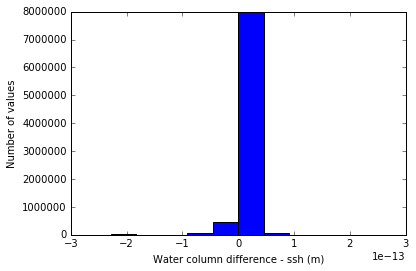

In [25]:
plt.hist(diff_ssh.flatten())
plt.xlabel('Water column difference - ssh (m)')
plt.ylabel('Number of values')

Ok, so the water column is expanding and compressing by exactly the ssh (to within reasonable error). That makes sense.

#### 2. Depth of bottom ocean point
Next, check to make sure the bottom hasn't moved! That is, the w point that represents the bathymetry shouldn't be affected. 

Note the depth variables are like a pressure, that is, gdepw(k=0) = 0 because it is at the surface. So the bottom feels the ssh moving up and down. So, compare gdepw_t[bottom] - ssh to gdepw_0[bottom].

In [26]:
mbathy = mesh_mask.variables['mbathy'][0,:,:]
bottom_0 = np.zeros(H_0[0,:,:].shape)
bottom_t = np.zeros(H_t.shape)
for i in np.arange(H_0[0,:,:].shape[1]):
    for j in np.arange(H_0[0,:,:].shape[0]):
        level = mbathy[j,i]
        bottom_0[j,i] = gdepw_0[0,level,j,i]
        bottom_t[:,j,i] = gdepw_t[:,level,j,i]

At a single point.

In [27]:
j=400
i=300
diff = bottom_t - bottom_0 - ssh

In [28]:
bottom_0[j,i]

23.375

In [29]:
bottom_t[:,j,i]

array([ 23.77571649,  23.44446205,  23.0530772 ,  22.68543079,
        22.46104562,  22.43946222,  22.631597  ,  22.99489061,
        23.45437265,  23.92271361,  24.28867064,  24.47369503,
        24.42435875,  24.16847472,  23.79394418,  23.3641584 ,
        22.97786956,  22.74423954,  22.7199077 ,  22.89045275,
        23.17842863,  23.5164112 ,  23.81913159,  23.97568495])

In [30]:
diff[:,j,i]

array([  8.69166276e-04,   1.50665308e-04,  -6.98260355e-04,
        -1.49569661e-03,  -1.98239487e-03,  -2.02920993e-03,
        -1.61246373e-03,  -8.24468832e-04,   1.72161701e-04,
         1.18800748e-03,   1.98177944e-03,   2.38310297e-03,
         2.27609108e-03,   1.72107082e-03,   9.08702680e-04,
        -2.35157594e-05,  -8.61388016e-04,  -1.36813865e-03,
        -1.42091514e-03,  -1.05099773e-03,  -4.26369280e-04,
         3.06725197e-04,   9.63334934e-04,   1.30290394e-03])

Over the whole domain, at a single time.

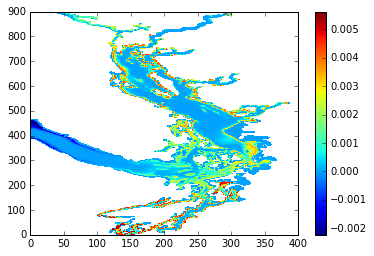

In [31]:
t=10
plt.pcolormesh(np.ma.array(diff[t], mask = 1-tmask[0,0,...]))
plt.colorbar()

In [32]:
print(np.max(diff))
print(np.min(diff))
print(np.mean(diff))

0.00629676075017
-0.00619416041651
-5.35265373469e-06


# Next
* Write this functions into a module grid_tools.py in salishsea_tools 
* Figure out U/V grids